In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX, XX, YY, RY, X
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import inner_product, Simulator
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz
from mindquantum.core.circuit import shift, Circuit
from mindquantum.core.operators import TimeEvolution, QubitOperator

import matplotlib.pyplot as plt
import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import numpy as np  
import random
import pandas as pd

qubit_num = 10

# 定义问题哈密顿量及问题层线路circuit1

In [2]:
def Construct_Hamiltonian_C():
    H_C = QubitOperator() 
    H_C += QubitOperator('',28)+ QubitOperator('Z0', -0.5) + QubitOperator('Z1', -4)+ QubitOperator('Z2', -1)+ QubitOperator('Z3', -4)+ QubitOperator('Z4', -1) + QubitOperator('Z5', -4)+ QubitOperator('Z6', -4.5)+ QubitOperator('Z7', -3)+ QubitOperator('Z8', -2.5)+ QubitOperator('Z9', -3.5)
    
    return H_C

In [3]:
H_C = Construct_Hamiltonian_C()
print (H_C)

  28 [] +
-1/2 [Z0] +
  -4 [Z1] +
  -1 [Z2] +
  -4 [Z3] +
  -1 [Z4] +
  -4 [Z5] +
-9/2 [Z6] +
  -3 [Z7] +
-5/2 [Z8] +
-7/2 [Z9]


In [4]:
hc = H_C - 28*QubitOperator(())
print (hc)

-1/2 [Z0] +
  -4 [Z1] +
  -1 [Z2] +
  -4 [Z3] +
  -1 [Z4] +
  -4 [Z5] +
-9/2 [Z6] +
  -3 [Z7] +
-5/2 [Z8] +
-7/2 [Z9]


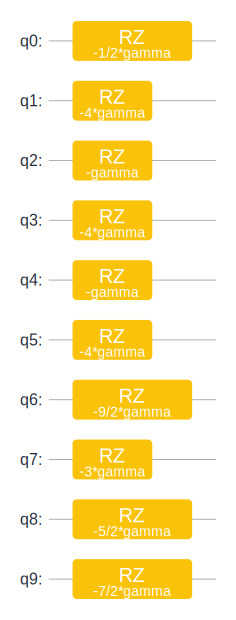

In [5]:
# circuit1是问题哈密顿量H_C中去掉单位算子I构造的电路，属于问题层(根据目标函数构建)
circuit1 = TimeEvolution(hc,{'gamma':0.5}).circuit
circuit1.svg()

# 构造混合层线路𝑒^(−𝑖𝛽𝐻_𝑀 )

In [6]:
def build_hb(para):              #自定义一个电路构建块hc（目标哈密顿量）， # 
    hb = Circuit()               # 创建量子线路
    
    hb += RX({para:2}).on(0, [3,6,9])  
    
    hb += RX({para:2}).on(1, [2,4,8])
    
    hb += RX({para:2}).on(2, [1,5,6])
    
    hb += RX({para:2}).on(3, [7,0,5])
    
    hb += RX({para:2}).on(4, [1,7,8])  
    
    hb += RX({para:2}).on(5, [2,3,9])
    
    hb += RX({para:2}).on(6, [0,2,7])
    
    hb += RX({para:2}).on(7, [3,4,6])
    
    hb += RX({para:2}).on(8, [1,4,9])
    
    hb += RX({para:2}).on(9, [0,5,8])

    
    
#    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

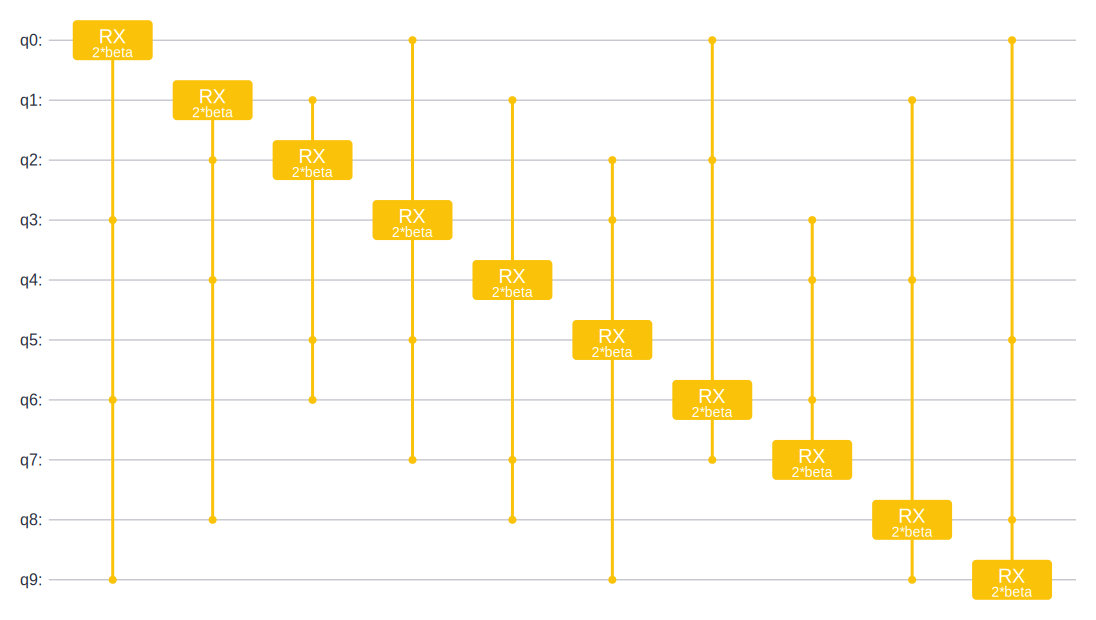

In [7]:
# pylint: disable=W0104
circuit2 = build_hb('beta')
circuit2.svg()
#circuit2.svg().to_file(filename='H_Bcircuit.svg')

# 总线路ansatz

In [8]:
def build_ansatz(p):                    # g是max-cut问题的图，p是ansatz线路的层数                      
    circ = UN(X, qubit_num)             # 制备初始态，创建量子线路
    for i in range(p):
        circ += TimeEvolution(hc, {f'γ{i}':0.5}).circuit       # 问题层H_C  （依目标函数而设计）
        circ += build_hb(f'β{i}')       # 混合层   （依约束条件1而设计）
        
    return circ

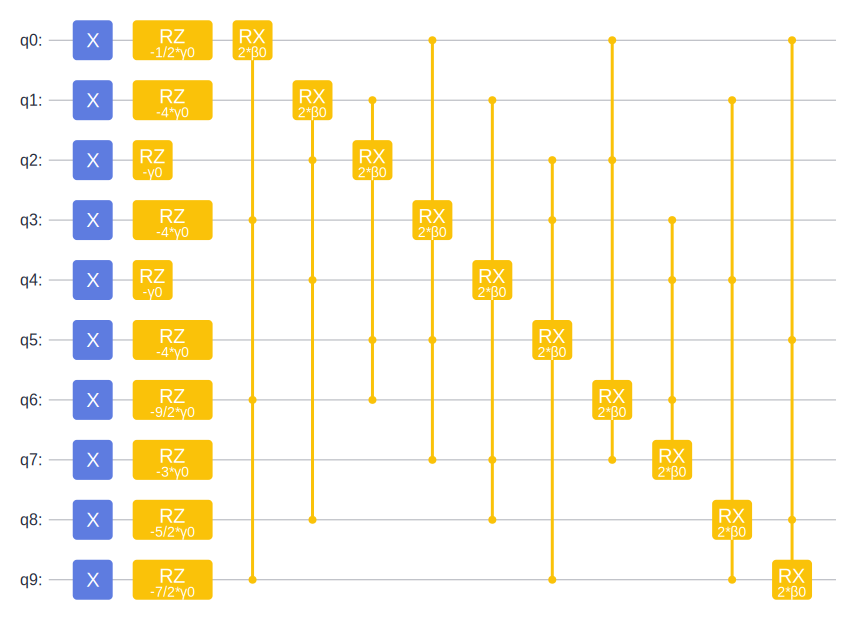

In [9]:
p = 1
build_ansatz(p).svg()                                      #展示完整的量子线路
#build_ansatz(p).svg().to_file(filename='Full_circuit.svg')   #展示完整的量子线路

# 单次实验

In [10]:
p = 10
ham = Hamiltonian(Construct_Hamiltonian_C()) # 生成哈密顿量
circ = build_ansatz(p)                  # 生成ansatz线路

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate = 0.1)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练                   # 对神经网络进行一步训练

for i in range(500):
    energy = train_net()    # 将神经网络训练一步并计算得到的结果。注意：每当'train_net()'运行一次，神经网络就训练了一步
    
    if i%10 == 0:
        print('i = %d energy = %f'%(i,energy))
    

i = 0 energy = 55.956848
i = 10 energy = 38.448032
i = 20 energy = 32.189590
i = 30 energy = 30.002335
i = 40 energy = 27.883461
i = 50 energy = 27.469681
i = 60 energy = 27.266315
i = 70 energy = 27.117508
i = 80 energy = 27.051918
i = 90 energy = 26.931231
i = 100 energy = 26.767399
i = 110 energy = 26.711208
i = 120 energy = 26.667416
i = 130 energy = 26.647760
i = 140 energy = 26.632521
i = 150 energy = 26.615417
i = 160 energy = 26.585808
i = 170 energy = 26.520922
i = 180 energy = 26.337139
i = 190 energy = 26.186110
i = 200 energy = 26.056988
i = 210 energy = 25.944412
i = 220 energy = 25.851160
i = 230 energy = 25.820122
i = 240 energy = 25.743183
i = 250 energy = 25.727499
i = 260 energy = 25.721315
i = 270 energy = 25.710136
i = 280 energy = 25.705692
i = 290 energy = 25.700539
i = 300 energy = 25.696362
i = 310 energy = 25.694935
i = 320 energy = 25.790022
i = 330 energy = 25.759745
i = 340 energy = 25.701269
i = 350 energy = 25.687204
i = 360 energy = 25.687614
i = 370 ener

In [11]:
pr = dict(zip(circ.params_name, net.weight.asnumpy())) # 获取线路参数
state = circ.get_qs(pr=pr)

v = [0]* 2**qubit_num
v[437] = 1       #这里指定的量子态v也是降序的qubits，即应该是q2q1q0,即应该是110，化为十进制是1*2^2+1*2^1+0*2^0=6
fid = np.abs(np.vdot(v,state))**2 
#print(('最优参数: {}'.format(pr)))
print('The F value is: {}'.format(energy))
print('获得解0111010011的概率: {}'.format(fid))
print('parameter:{}'.format(pr))

The F value is: [25.687605]
获得解0111010011的概率: 0.824681772221398
parameter:{'γ0': 0.019053048, 'β0': -0.33202356, 'γ1': 0.72972107, 'β1': -0.4047189, 'γ2': -0.45705998, 'β2': 0.24711639, 'γ3': 0.15913412, 'β3': 0.74898595, 'γ4': 0.68803084, 'β4': 0.14619961, 'γ5': -1.0988375, 'β5': -0.1582577, 'γ6': -0.22866115, 'β6': -0.6020558, 'γ7': -0.18751349, 'β7': -0.6411866, 'γ8': -1.1998959, 'β8': 0.36347854, 'γ9': -0.3035819, 'β9': 0.083122544}


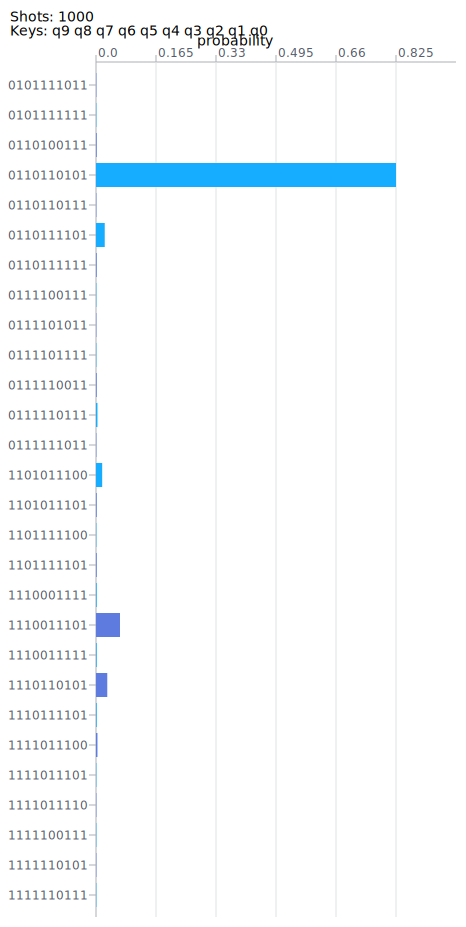

In [12]:
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()

# _main_文件
主要是为了比较期望值和成功概率随层数p的变化情况

# 以Excel（.xlsx）文件的形式输出训练结果

In [ ]:
if __name__ == "__main__":
    #创建一个空的DataFrame来存储结果
    results = []

    for p in range(1, 11):
        print('The p value is: {}'.format(p))
        for t in range(1, 4):
            ham = Hamiltonian(Construct_Hamiltonian_C()) # 生成哈密顿量
            circ = build_ansatz(p)                  # 生成ansatz线路

            ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
            sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
            grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
            net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
            opti = nn.Adam(net.trainable_params(), learning_rate = 0.1)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
            train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练                   
                
            
            for i in range(500):
                energy = train_net()
                #if i%500 == 0:
                #    print('i = %d energy = %f'%(i,energy))
                
            pr = dict(zip(circ.params_name, net.weight.asnumpy())) 
            state = circ.get_qs(pr=pr)
            
            v = [0]* 2**qubit_num
            v[437] = 1
            fid = np.abs(np.vdot(v,state))**2 

            # 将结果添加到列表
            results.append({"p": p, "t": t, "energy": energy, "fidelity": fid})
            
            #命令交互行输出，便于区分（实际上没啥必要）            
            print('t: {}'.format(t))

        # 将列表转换为DataFrame
        df = pd.DataFrame(results)

        # 将DataFrame写入Excel文件
        df.to_excel(r"D:\pyBUPTAIML\mywork\远程服务器备份\liguanghui（1paper)\科研\MWVC\MWVC paper\MWVC_QAOA+_v2\实验4\code\箱型图code\regular graph code\RG10-3.xlsx", index=False)
    